In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
for x in range(len(signals_all)):
    print("'" + signals_all[x] + "',")

'2Mu2E_100GeV_0p25GeV_0p02mm',
'2Mu2E_100GeV_0p25GeV_0p2mm',
'2Mu2E_100GeV_0p25GeV_2p0mm',
'2Mu2E_100GeV_0p25GeV_10p0mm',
'2Mu2E_100GeV_0p25GeV_20p0mm',
'2Mu2E_100GeV_1p2GeV_0p096mm',
'2Mu2E_100GeV_1p2GeV_0p96mm',
'2Mu2E_100GeV_1p2GeV_9p6mm',
'2Mu2E_100GeV_1p2GeV_48p0mm',
'2Mu2E_100GeV_1p2GeV_96p0mm',
'2Mu2E_100GeV_5p0GeV_0p4mm',
'2Mu2E_100GeV_5p0GeV_4p0mm',
'2Mu2E_100GeV_5p0GeV_40p0mm',
'2Mu2E_100GeV_5p0GeV_200mm',
'2Mu2E_100GeV_5p0GeV_400mm',
'2Mu2E_150GeV_0p25GeV_0p013mm',
'2Mu2E_150GeV_0p25GeV_0p13mm',
'2Mu2E_150GeV_0p25GeV_1p3mm',
'2Mu2E_150GeV_0p25GeV_6p7mm',
'2Mu2E_150GeV_0p25GeV_13p0mm',
'2Mu2E_150GeV_1p2GeV_0p064mm',
'2Mu2E_150GeV_1p2GeV_0p64mm',
'2Mu2E_150GeV_1p2GeV_6p4mm',
'2Mu2E_150GeV_1p2GeV_32p0mm',
'2Mu2E_150GeV_1p2GeV_64p0mm',
'2Mu2E_150GeV_5p0GeV_0p27mm',
'2Mu2E_150GeV_5p0GeV_2p7mm',
'2Mu2E_150GeV_5p0GeV_27p0mm',
'2Mu2E_150GeV_5p0GeV_130p0mm',
'2Mu2E_150GeV_5p0GeV_270p0mm',
'2Mu2E_200GeV_0p25GeV_0p01mm',
'2Mu2E_200GeV_0p25GeV_0p1mm',
'2Mu2E_200GeV_0p25GeV_1p0mm',
'2Mu2

In [3]:
# S  = [
# '2Mu2E_500GeV_5p0GeV_0p8mm', 
# '2Mu2E_500GeV_5p0GeV_80p0mm',
# '2Mu2E_500GeV_0p25GeV_0p004mm',
# '2Mu2E_500GeV_0p25GeV_4p0mm',
# ]
S = [
'2Mu2E_500GeV_5p0GeV_0p08mm',
'2Mu2E_500GeV_5p0GeV_0p8mm',
'2Mu2E_500GeV_5p0GeV_8p0mm',
'2Mu2E_500GeV_5p0GeV_40p0mm',
'2Mu2E_500GeV_5p0GeV_80p0mm',

# '2Mu2E_200GeV_5p0GeV_0p2mm',
# '2Mu2E_200GeV_5p0GeV_2p0mm',
# '2Mu2E_200GeV_5p0GeV_20p0mm',
# '2Mu2E_200GeV_5p0GeV_100p0mm',
# '2Mu2E_200GeV_5p0GeV_200p0mm',

# '2Mu2E_1000GeV_5p0GeV_0p04mm',
# '2Mu2E_1000GeV_5p0GeV_0p4mm',
# '2Mu2E_1000GeV_5p0GeV_4p0mm',
# '2Mu2E_1000GeV_5p0GeV_20p0mm',
# '2Mu2E_1000GeV_5p0GeV_40p0mm',
]



In [4]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
     "DYJetsToMuMu_M50",
     ]
TT = [ 
     "TTJets",
     ]

bgs= QCD + DY + TT


In [5]:
def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        # print( output_bg["out"][x]["hists"].keys())
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist


In [6]:
histogram_list = [

 "mu_lj_pfMuon_max_dxy_XLowRange",
"mu_lj_pfMuon_min_dxy_XLowRange",
"pf_mu_lj_pfMuon_min_dxy_XLowRange",
    "pf_dsa_mu_lj_pfMuon_min_dxy_XLowRange",
 "mu_lj_muonN",
 "mu_lj_pfMu_n",
"mu_lj_dsaMu_n",
 "mu_lj_pfMu_trkNumPixelHits",
 "mu_lj_pfMu_trkNumTrkLayers",
 "mu_lj_pfMu_nTrackerLayers",
 "mu_lj_pfMu_nStations",
 "pf_mu_lj_pfMu_trkNumPixelHits",
"pf_mu_lj_pfMu_trkNumTrkLayers",
 "pf_dsa_mu_lj_pfMu_trkNumPixelHits",
"pf_dsa_mu_lj_pfMu_trkNumTrkLayers",
   "pf_mu_lj_pfMuon_min_trkNumTrkLayers",
    "pf_mu_lj_pfMuon_max_trkNumTrkLayers",
   "pf_mu_lj_pfMuon_min_trkNumPixelHits",
   "pf_mu_lj_pfMuon_max_trkNumPixelHits",
  "mu_lj_pfMu_max_trkNumPixelHits",
   "mu_lj_pfMu_min_trkNumPixelHits",
   "mu_lj_pfMu_min_trkNumTrkLayers",
   "mu_lj_pfMu_max_trkNumTrkLayers",
   "mu_lj_pfMu_min_nTrackerLayers",
   "mu_lj_pfMu_max_nTrackerLayers",
 
# "pf_dsa_mu_lj_pfMu_max_trkNumTrkLayers",
#  "pf_dsa_mu_lj_pfMu_min_trkNumTrkLayers",
"egm_lj_electron_lostHits",

]

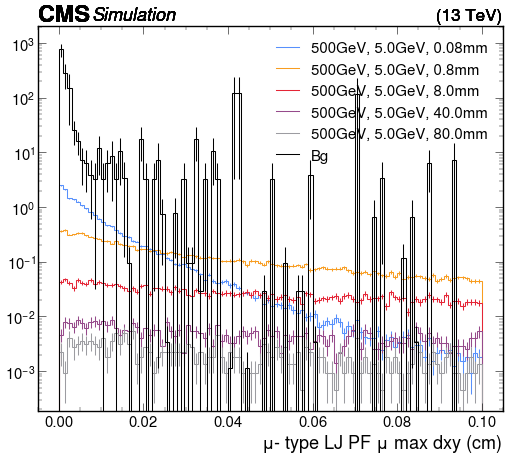

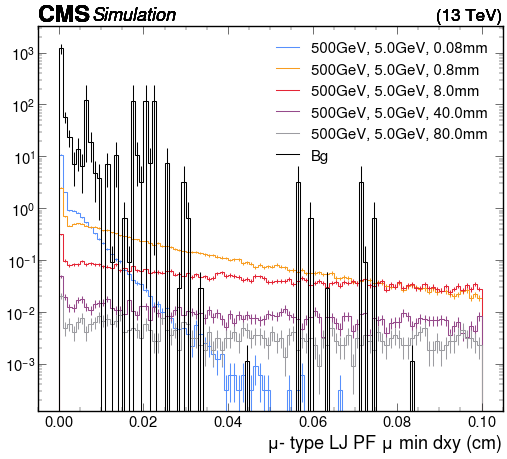

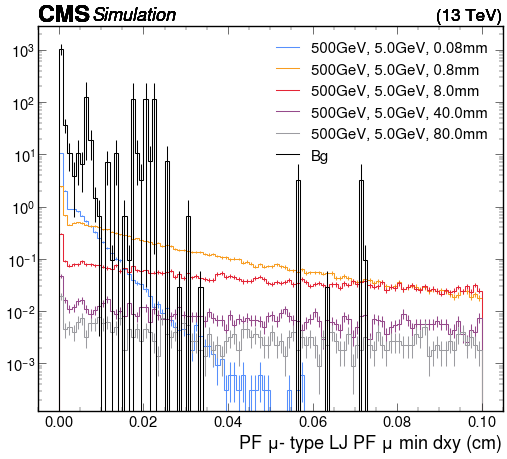

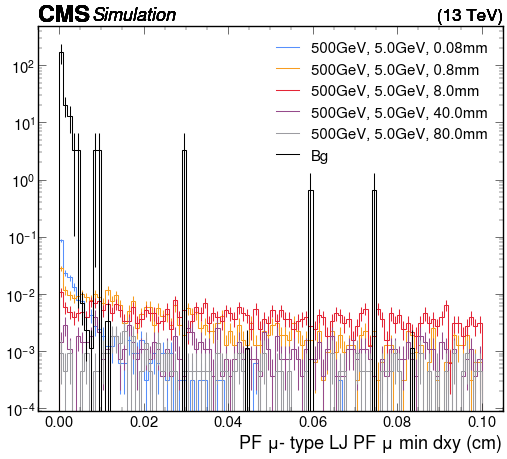

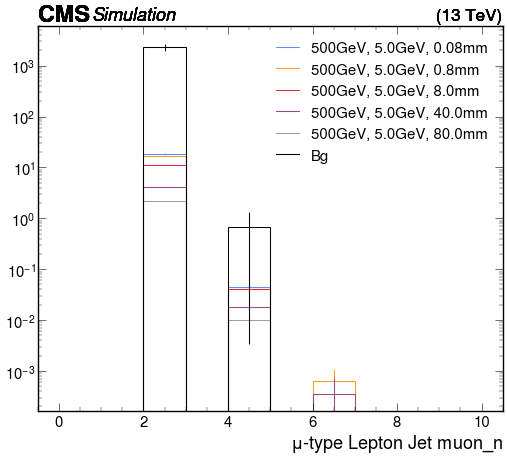

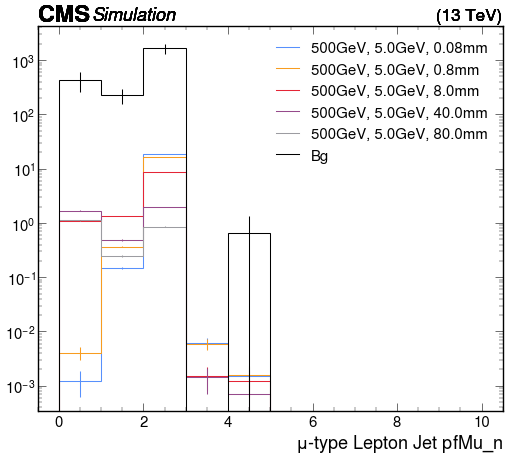

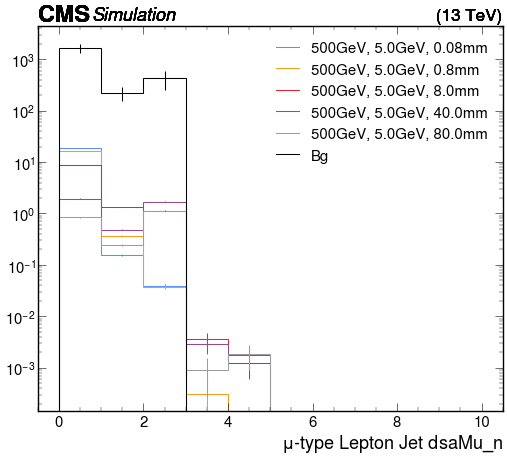

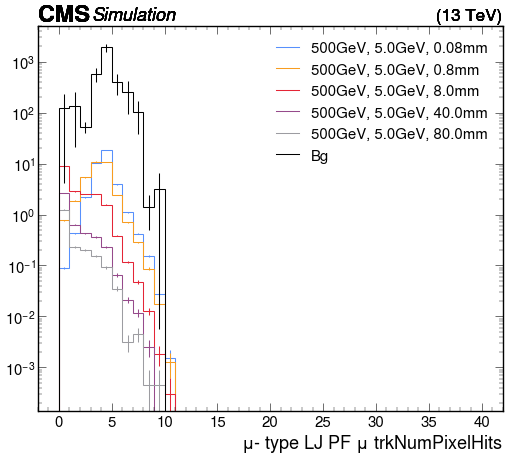

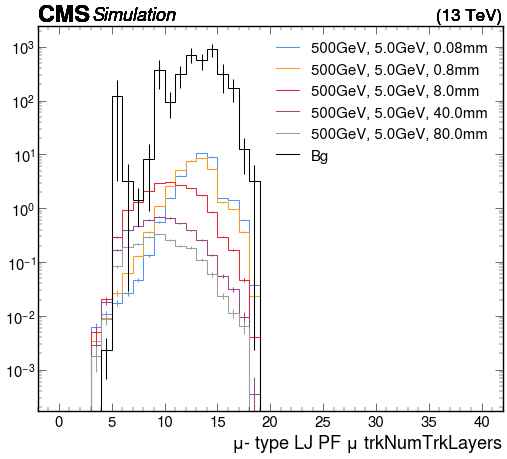

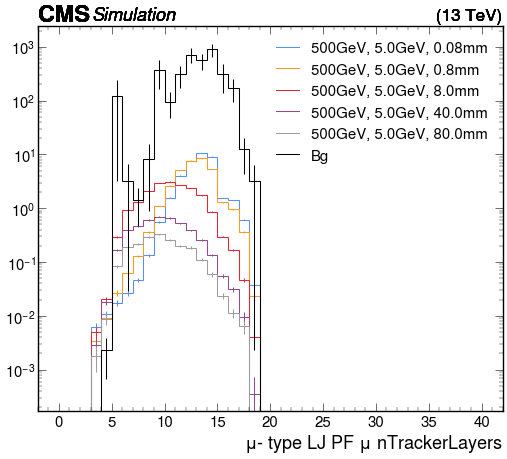

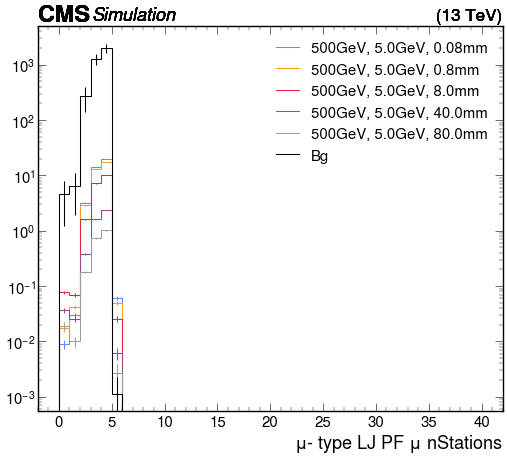

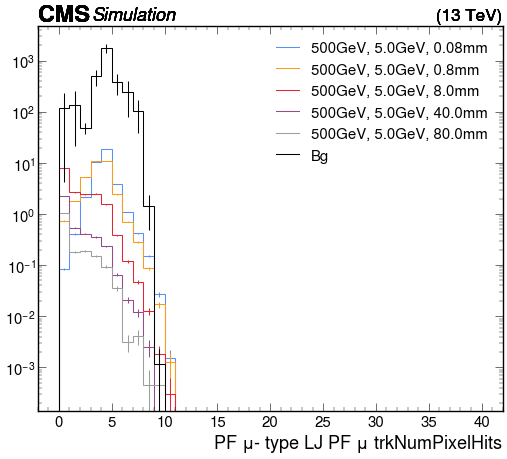

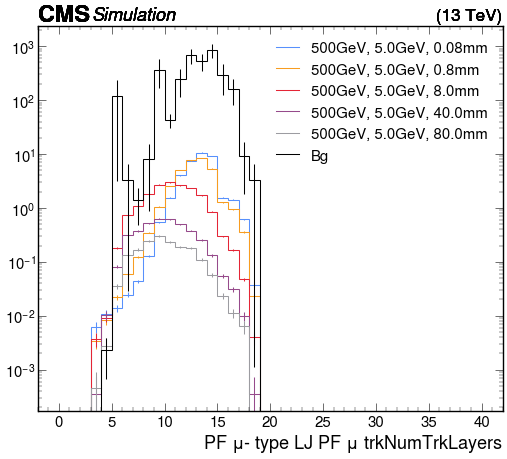

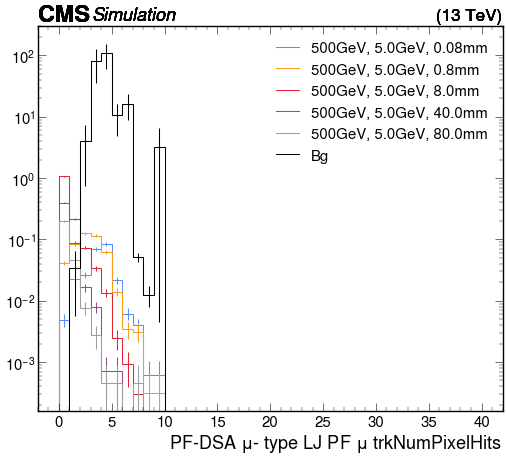

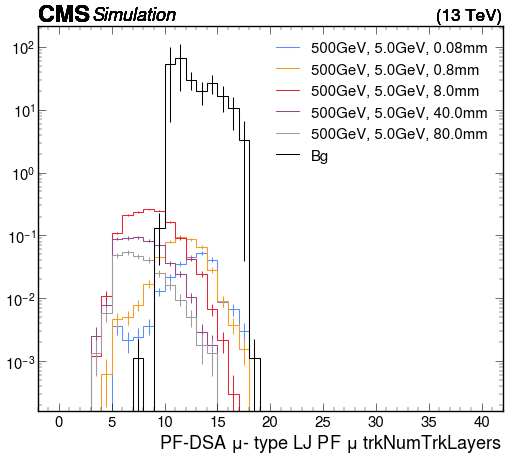

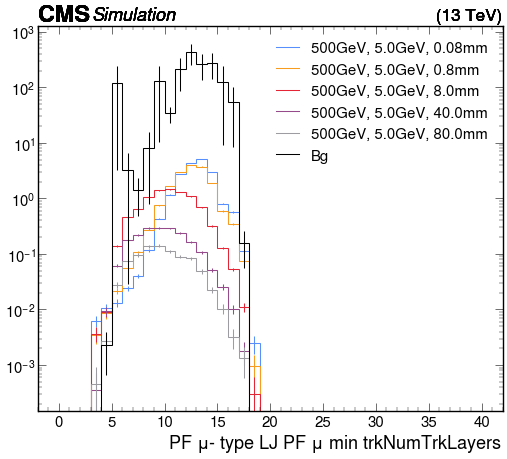

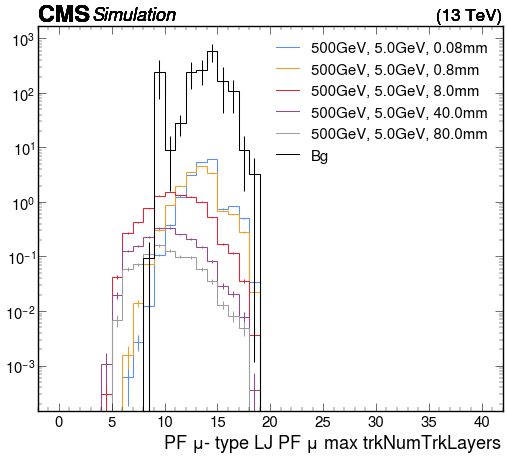

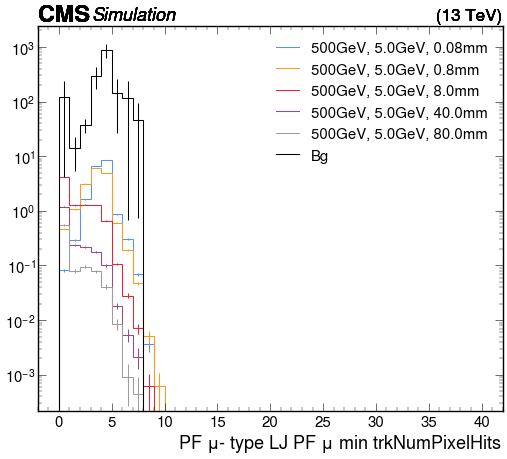

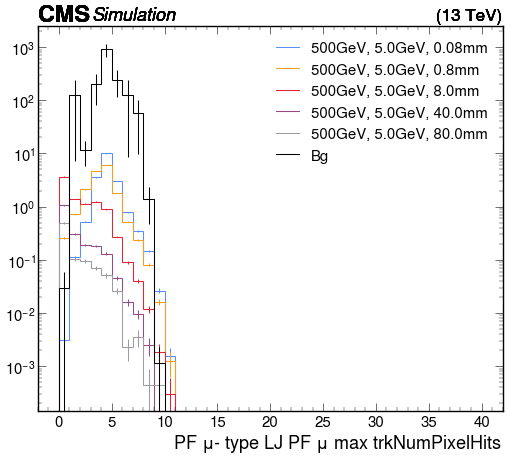

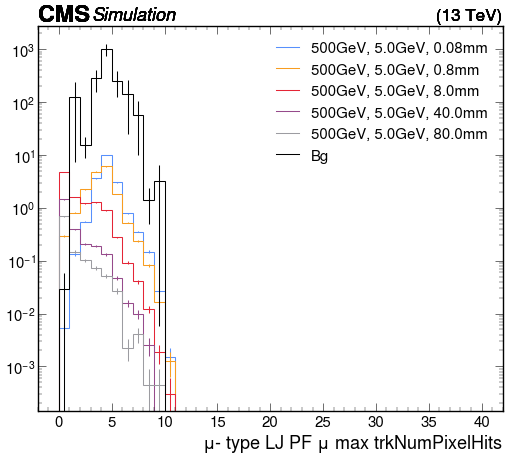

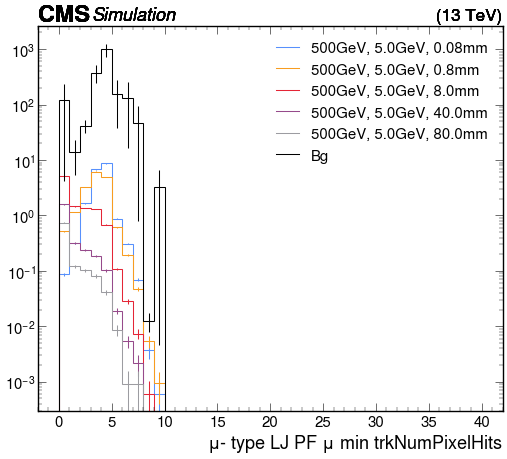

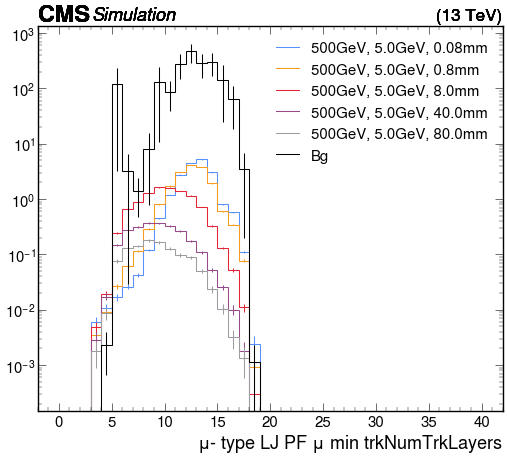

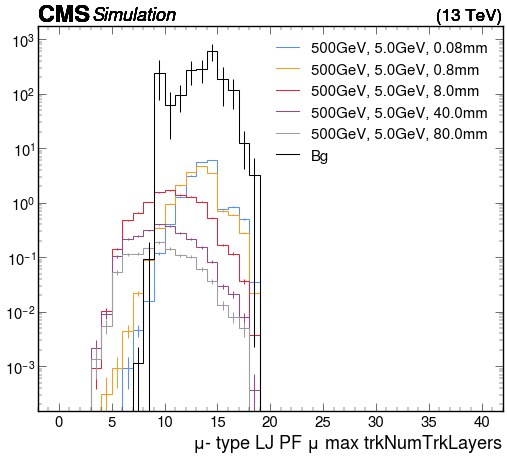

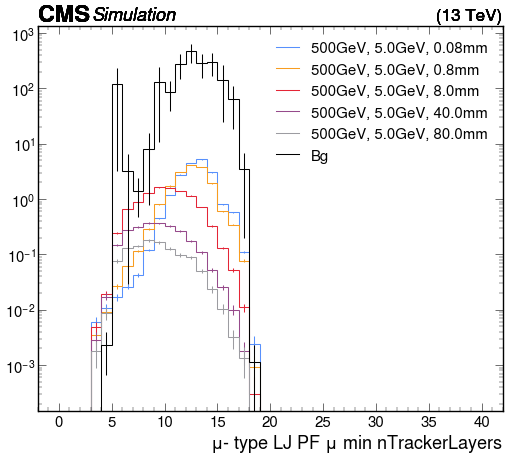

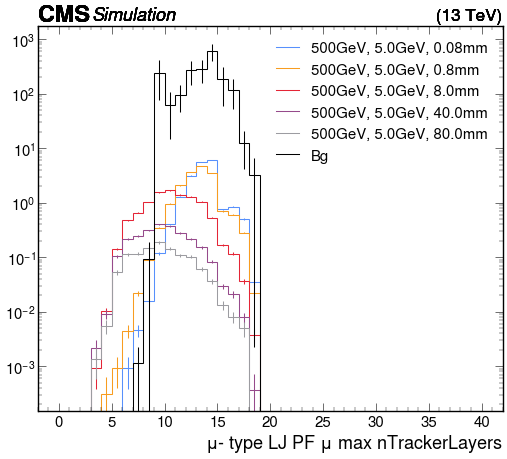

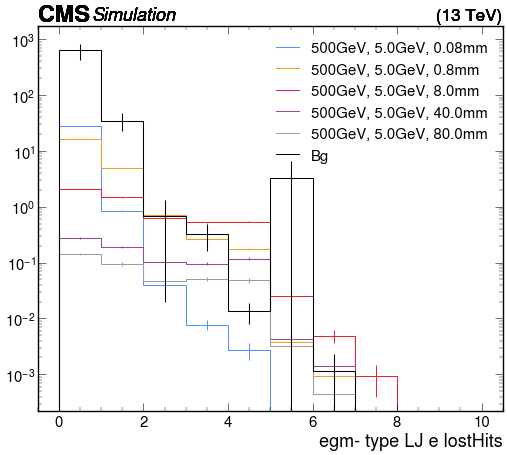

In [7]:

channel_name = "base_ljObjCut_ljIso_2lj"
output_signal = coffea.util.load(f"output_signal{channel_name}.coffea" )
label_list =[]
for s in S:
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
label_list.append("Bg")

# sum_bg = sum_bgs_hist(QCD, histogram_name,channel_name )
for histogram_name in histogram_list:
    plt.figure(figsize=(12, 10))
    for s in S:
        # print(s)
        # print(output_signal["out"][s]["hists"].keys())
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :]

    # print(histogram.values())
        utilities.plot(histogram, flow ="none", yerr=True, density=False)
    sum_bg = sum_bgs_hist(bgs, histogram_name,channel_name )
   
    utilities.plot(sum_bg, flow ="none", yerr=True, color  ="k", density=False)
    # plt.title(histogram_name)
    # plt.xlabel("")

    plt.yscale("log")

    plt.legend(label_list)
    plt.show()
    plt.close()
    

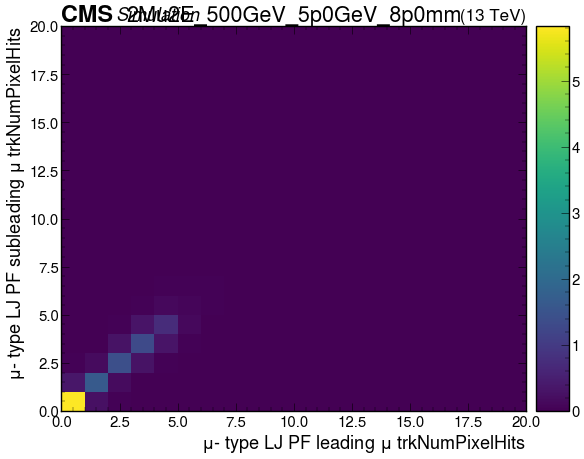

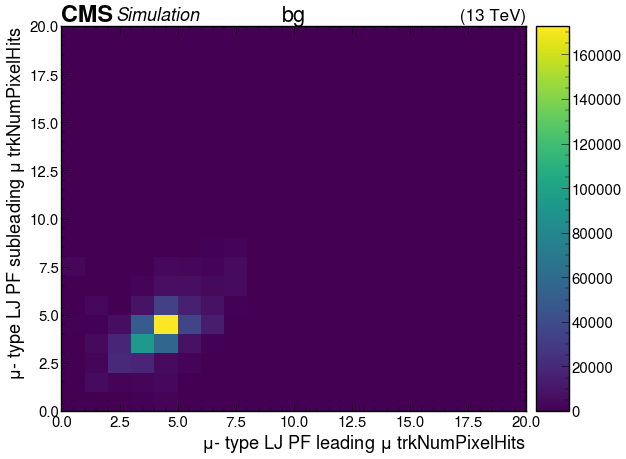

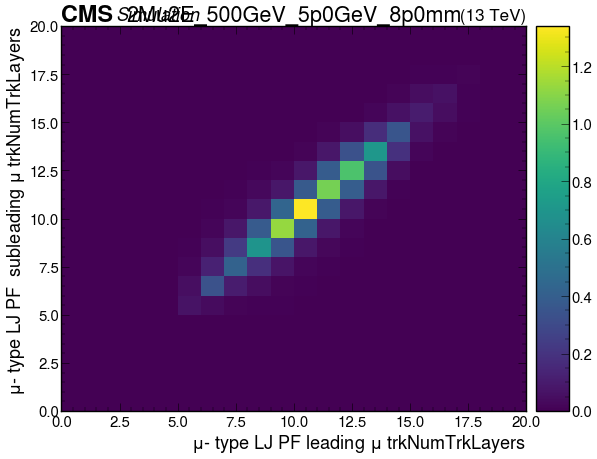

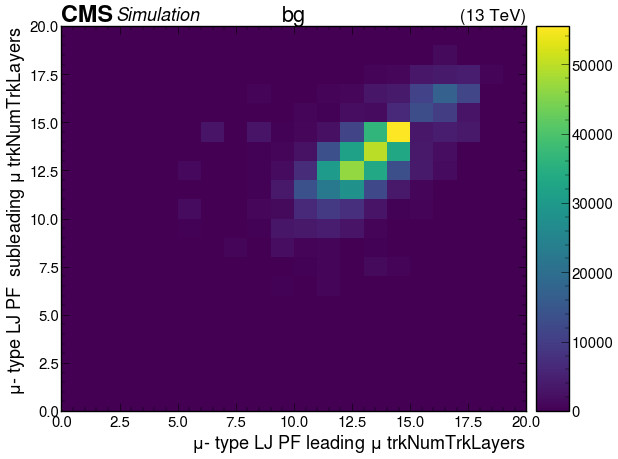

In [8]:

histogram_list = [ "mu_lj_pfMu_trkNumTrkPixelHits_leading_subleading",
"mu_lj_pfMu_trkNumTrkLayers_leading_subleading"]
def sum_bgs_hist_2d(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        # print( output_bg["out"][x]["hists"].keys())
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist


channel_name = "base_ljObjCut_ljIso"
output_signal = coffea.util.load(f"output_signal{channel_name}.coffea" )
label_list =[]
for s in S:
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
label_list.append("Bg")

# sum_bg = sum_bgs_hist(QCD, histogram_name,channel_name )
for histogram_name in histogram_list:
    
    for s in [S[2]]:
        plt.figure(figsize=(12, 10))
        # print(s)
        # print(output_signal["out"][s]["hists"].keys())
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :, :]
        # plt.xlabel(histogram_name)
        utilities.plot(histogram, flow ="none",)
        plt.title(s)


        plt.show()
        plt.close()

        
    plt.figure(figsize=(12, 10))
    sum_bg = sum_bgs_hist_2d(bgs, histogram_name,channel_name )
    utilities.plot(sum_bg, flow ="none",  )
    plt.title("bg")
    plt.show()
    plt.close()
    # plt.title(histogram_name)
    
    

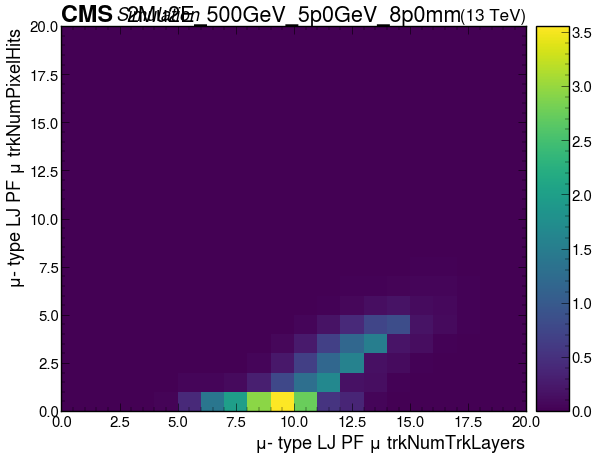

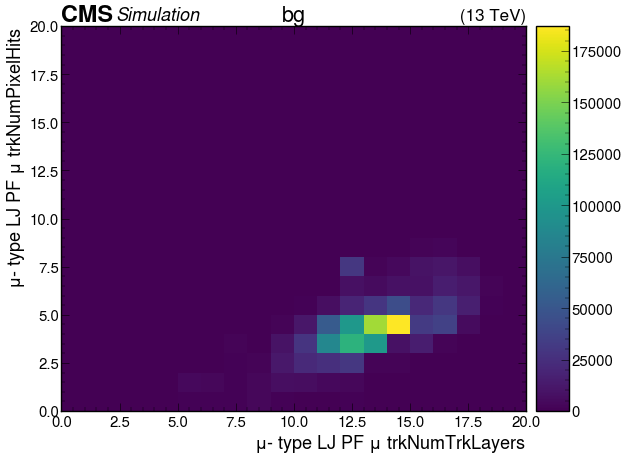

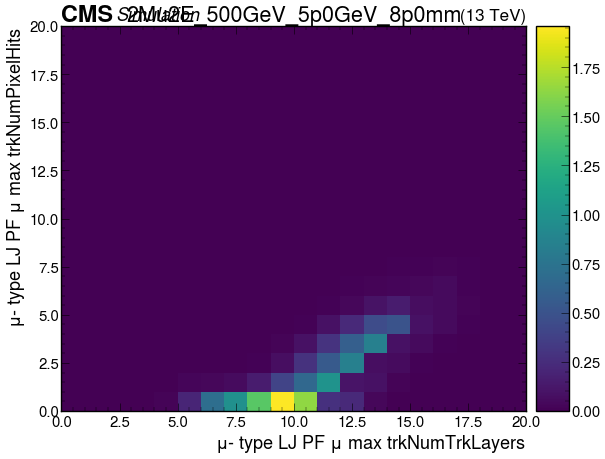

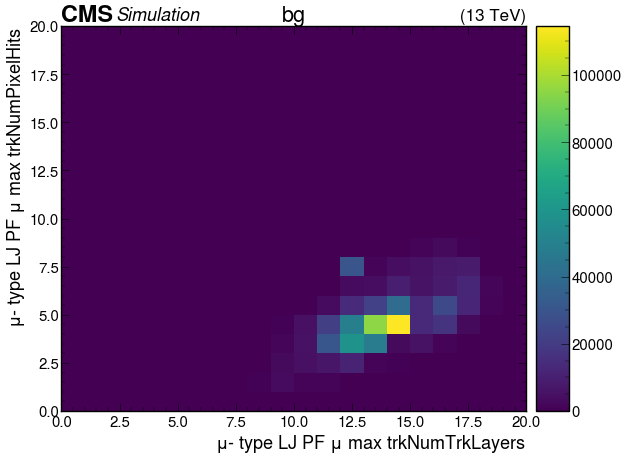

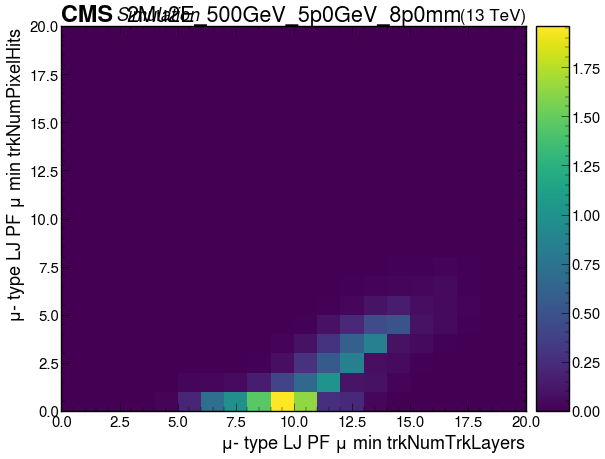

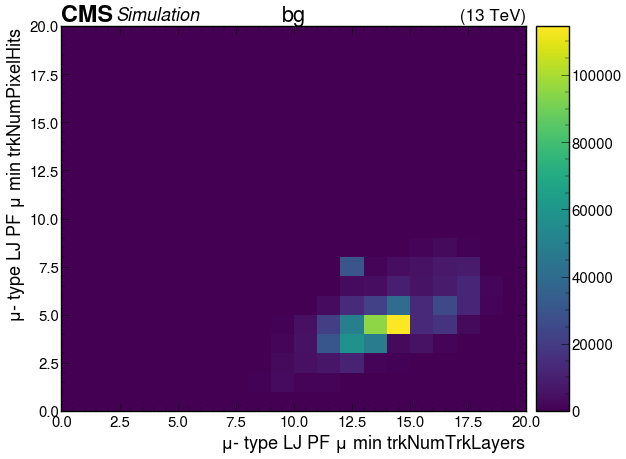

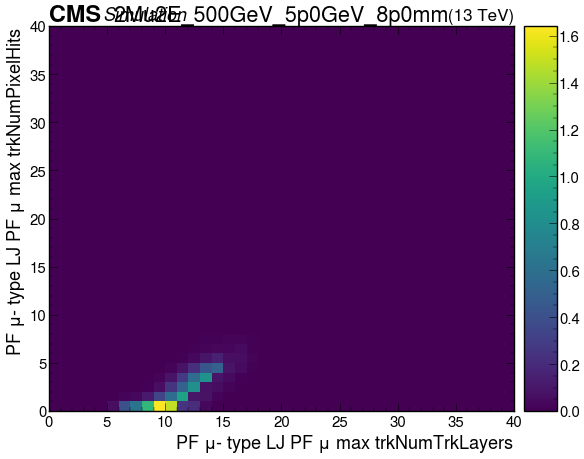

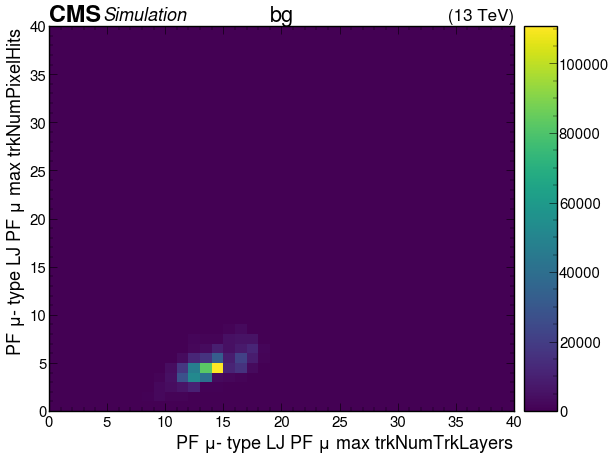

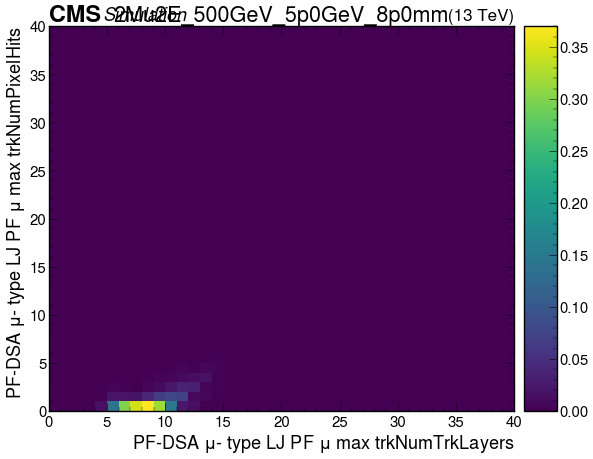

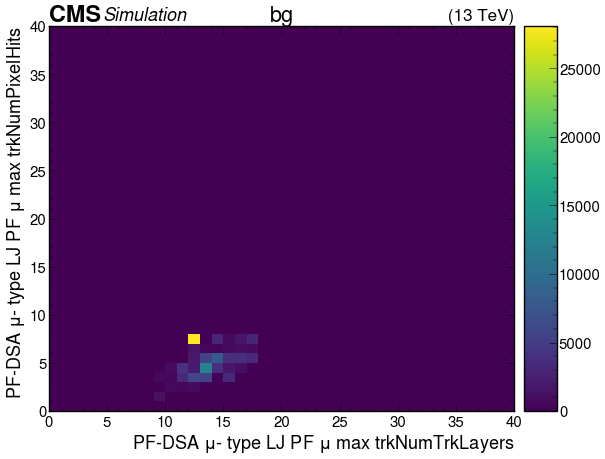

In [9]:
histogram_list = ["mu_lj_pfMu_trkNumTrkLayers_trkNumPixelHits",
 "mu_lj_pfMu_max_trkNumTrkLayers_max_trkNumPixelHits",
 "mu_lj_pfMu_min_trkNumTrkLayers_min_trkNumPixelHits",
"pf_mu_lj_pfMuon_max_trkNumTrkLayers_max_trkNumPixelHits",
                 "pf_dsa_mu_lj_pfMuon_max_trkNumTrkLayers_max_trkNumPixelHits",]
def sum_bgs_hist_2d(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        # print( output_bg["out"][x]["hists"].keys())
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist


channel_name = "base_ljObjCut_ljIso"
output_signal = coffea.util.load(f"output_signal{channel_name}.coffea" )
label_list =[]
for s in S:
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
label_list.append("Bg")

# sum_bg = sum_bgs_hist(QCD, histogram_name,channel_name )
for histogram_name in histogram_list:
    
    for s in [S[2]]:
        plt.figure(figsize=(12, 10))
        # print(s)
        # print(output_signal["out"][s]["hists"].keys())
        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :, :]
        # plt.xlabel(histogram_name)
        utilities.plot(histogram, flow ="none",)
        plt.title(s)


        plt.show()
        plt.close()

        
    plt.figure(figsize=(12, 10))
    sum_bg = sum_bgs_hist_2d(bgs, histogram_name,channel_name )
    utilities.plot(sum_bg, flow ="none",  )
    plt.title("bg")
    plt.show()
    plt.close()
    # plt.title(histogram_name)
    
    